In [1]:
# from spacy import load, prefer_gpu 
from helpers import get_dates_from_file
from glob import glob
from tqdm import tqdm
from datetime import datetime
import pandas as pd 
from spacy import load, prefer_gpu
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
# !pip install https://huggingface.co/csae8092/de_MRP_NER/resolve/main/de_MRP_NER-any-py3-none-any.whl --user
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner-with-dates")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner-with-dates")
prefer_gpu()

# Parameters
useSpacy = True
folder = "./results/Berlin/1879"
language = "de"
model_dict = {
    "fr" : pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple", device = 0),
    "de" : load("de_RTA_NER"),
    # "en" : load("en_core_web_sm")

}

nlp = model_dict[language]

C:\Users\bench\anaconda3\envs\p38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bench\anaconda3\envs\p38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\bench\anaconda3\envs\p38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
# Compute the results from the previously created files (using fileCreater.ipynb)

results = []
nb = []
for file in tqdm(glob(folder + "/*/*.csv")):        # Compute the nb of dates
    results.append(get_dates_from_file(file,nlp,useSpacy,rt = 0.75, lt = 15))
for file in tqdm(glob(folder + "/*/*.csv")): # Get the length of the text from each date
    nb.append(pd.read_csv(file)["Length"].sum())
df = pd.DataFrame(results, columns = ["Date", "Number of dates"])




100%|██████████| 363/363 [00:02<00:00, 157.45it/s]


<AxesSubplot:xlabel='Date', ylabel='ratio'>

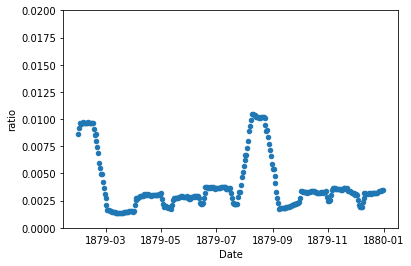

In [5]:
# Plotting the results
df["length"] = nb
df["ratio"] = (df["Number of dates"]/df["length"]).rolling(window = 30).mean() # You can configure the rolling average window size, default 8
df.plot(x= "Date", y = "ratio", kind = "scatter", ylim = (0,0.02))